# Welcome to Austin's Reworked Temperature-Dependent EIS Processing Suite of Functionality!

As of 5/26/2025, this is the most up-to-date EIS analysis and processing code that we have for the Maughan lab. It works to import Austin's temperature-dependent EIS .DTA files in cooperation with "new Quincy". EIS data files should be stored in a single folder (this code assumes continuous EIS collection while Quincy controls and monitors the oven). An update to this code will be developed when potentiostat control is added to Quincy. All code should be backwards compatible with previous iterations of our EIS code after the 'all experiments' dictionary is generated.

In [2]:
import pandas as pd
import os
from pathlib import Path

from PyEIS import *
from datetime import datetime, timedelta, timezone
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as mcolors
from matplotlib.pyplot import rc
import matplotlib.ticker as ticker
import csv
import glob
import statistics
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import math
from math import pi
import re
from collections import defaultdict
import random
from scipy import stats





rc('text',usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
rc('text.latex', preamble=r'\usepackage{sfmath}')

In the cell below, you will specify:

1. Where quincy wrote his logs
2. Where your EIS lives
3. The parent folder for your exported data
4. sample name and material name (use Latex formatting for material name)
5. diameter and height (as well as associated error) of your pellet in mm
6. common parameters for PyEIS-- generally just the frequency mask for targetting a certain frequency range (high frequency limit, low frequency limit)

In [4]:
#Welcome to lilshotty's user input block! Most of the information needed for this code to run* is provided here
#*I make no representations as to whether the code will run well or provide good fits

#this is the folder in which quincy wrote all of his records. It will have a f*ckton of nested folders in it.
quincy_data_path=Path(r"C:\Users\austi\OneDrive - Colorado School of Mines\Research\Data\EIS\Data\Data for analysis\6_2_2025\Quincy Data Log")
#this is the folder in which all of your .DTA files are for a given experiment
EIS_folder_path=Path(r"C:\Users\austi\OneDrive - Colorado School of Mines\Research\Data\EIS\Data\Data for analysis\6_2_2025\1_150_C_DB_Pellet_2_T_dep")




#This is the folder in which your exported data will be saved (subfolders will be generated later.
save_folder=Path(r"C:/Users/austi/OneDrive - Colorado School of Mines/Research/Data/EIS/Data/Analyzed Data/1_150/1_150_C_DB_Pellet_2")

#uses Path to convert any backslashes to forward slashes in Quincy, EIS, and Save folder paths
EIS_folder_path_added_fwdslash=f"{EIS_folder_path.as_posix()}/"
quincy_data_path=quincy_data_path.as_posix()
save_folder=save_folder.as_posix()



#set this flag to True if you are ready to export fitted datasets
ready2export=False



#samplename and materialname are included in output files, so change them as appropriate, used in generating figure titles and metadata
samplename='AMS_1_150_C_DB'
materialname='Li$_{6}$PS$_{5}$Br$_{}$'

#INPUT DIAMETER AND HEIGHT OF PELLET HERE!
#diameter in mm
diameter = 6
#pellet height in mm
height = 1.475

#Errors in the thickness and height, generally no need to change this.
#err in pellet diameter (mm)
diameter_err=0.01
#err in pellet height (mm)
height_err=0.001

#EIS fitting mask
common_params = {
    'mask': [10**7, 1000]}


In [7]:
#Function Block!!!

#This function finds all folders labelled "Hold" in the quincy file sorting system and reads the metadata to find the start time, end time, and temperature
def extract_hold_metadata(parent_path):
    hold_data = []

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(parent_path):
        # Check if this folder contains 'Hold' in its name
        if "Hold" in os.path.basename(root):
            metadata_path = os.path.join(root, 'metadata.csv')
            if os.path.isfile(metadata_path):
                try:
                    # Read the metadata.csv file
                    df = pd.read_csv(metadata_path)

                    # Extract the first row
                    row = df.iloc[0]
                    
                    start_time = datetime.strptime(row.iloc[0], '%d %B %Y %I:%M:%S %p')
                    end_time = datetime.strptime(row.iloc[1], '%d %B %Y %I:%M:%S %p')
                    setpoint = float(row.iloc[3])

                    hold_data.append({
                        'folder': root,
                        'start_time': start_time,
                        'end_time': end_time,
                        'setpoint_C': setpoint
                    })
                except Exception as e:
                    print(f"Failed to read {metadata_path}: {e}")

    return pd.DataFrame(hold_data)

#This function reads a given EIS dataset and returns the associated datetime
def extract_EIS_time(file_path):
    # Open the file in read mode
    with open(file_path, 'r', encoding='latin-1') as file:
        # Read the entire file content
        lines = file.readlines()

        # Look for the lines containing the date and time using regex
        #This reads the resulting file string for a string LABEL + tab + 2 digits / 2 digits / 4 digits
        date_regex = re.compile(r'DATE\tLABEL\t(\d{1,2}/\d{1,2}/\d{4})\tDate')
        time_regex = re.compile(r'TIME\tLABEL\t(\d{1,2}:\d{2}:\d{2})\tTime')
        date = None
        time = None

        for line in lines:
            # Check if the line matches the date pattern
            if date_regex.search(line):
                date = date_regex.search(line).group(1) #this takes the first string found
                #print(date)
            # Check if the line matches the time pattern
            if time_regex.search(line):
                time = time_regex.search(line).group(1)
                #print(time)
    #puts date and time in a single string
    date_time_str = date+'-'+time
    # Define the format in which the date and time are provided
    date_time_format = '%m/%d/%Y-%H:%M:%S'
    # Convert the string to a datetime object
    dt_object = datetime.strptime(date_time_str, date_time_format)
        
    return dt_object


#Generates a dictionary of filename lists, where the key is the temperature and the list is the .dta files that are from the hold at that temperature
#Will throw an error for every empty .DTA file-- don't worry about that, just check that the first one is the first empty dta file
#Built so that it will do this process in numerical order !!!! We will need to adjust this function when QUINCY gets EIS capabilities again
def associate_EIS_with_temperature(EIS_folder_path, ovendata, printerrors=True):
    # Helper function to extract number from filename
    def extract_number(filename):
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')  # Send non-numeric to end

    # Get and sort .DTA files by number
    dta_files = sorted(
        [f for f in os.listdir(EIS_folder_path) if f.endswith('.DTA')],
        key=extract_number
    )

    # Dict to hold files grouped by temperature
    temp_to_files = defaultdict(list)
    
    # Loop through numerically sorted files
    for filename in dta_files:
        file_path = os.path.join(EIS_folder_path, filename)
        try:
            file_time = extract_EIS_time(file_path)
        except Exception as e:
            if printerrors:
                print(f"Could not read time from {filename} because it is likely empty: {e}")
            continue

        # Match file time to temperature hold window
        for _, row in ovendata.iterrows():
            if row['start_time'] <= file_time <= row['end_time']:
                temp_to_files[row['setpoint_C']].append(os.path.basename(file_path))
                break

    # Optional: sort dictionary by temperature
    temp_to_files_sorted = dict(sorted(temp_to_files.items()))
    return temp_to_files_sorted




def make_pyeis_experiments(files_found_dict,EIS_folder_path, common_params):
    # Dictionary to store the EIS_exp instances
    all_experiments = {}
    
    # Iterate through the keys in files_found_dict
    for temp, file_list in files_found_dict.items():
        temp_experiments = {}
        for idx, filename in enumerate(file_list, start=1):
            #print(filename)
            params = {'path': EIS_folder_path, 'data': [filename]}
            params.update(common_params)
            
            
            #var_name = f"Ex{idx}_Temp{temp}"
            
            # Call the EIS_exp function and store the instance in the dictionary, dictionary has two keys
            #temp_experiments[idx] = EIS_exp(**params)
        
            # Store the experiments for each temperature in the overall dictionary
            #this generates the 'all_experiments' dictionary with a two part key. The first part of the key is the temperature, while the second part of the key is the replicate at that temperature.
            #all_experiments[temp,idx] = temp_experiments[idx]
            all_experiments[temp,idx]=EIS_exp(**params)
    return all_experiments

def cull_the_herd(dictionary, sickly=None):
    workingdictionary={}
    workingdictionary=dictionary.copy()
    removed_values={}
    if sickly!=None:
        for key in sickly:
            removed_values[key] = workingdictionary.pop(key, None)  # pop with default to avoid KeyError
        print(f'\nI have culled the sick datasets: {sickly}, see the graveyard to pay your respects.\n')
    else:
        print('Congratulations, your flock is healthy')
    return workingdictionary, removed_values
    
#Converts pyeis experiment objects into easily handled dataframes
def make_nyquist(experiments):
    #generates a frequency range for any simulations
    f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
    #print(f_range[0][:4]) #First 5 points in the freq. array
    #print()
    #print(f_range[1][:4]) #First 5 points in the angular freq. array
    
    
    #This chunk of code generates a simulated dataset using the parameters from the initial modelling
    sim={}
    # Iterate through the outer dictionary (temperature-wise experiments)
    for exp_name, exp_instance in experiments.items():
        sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
        sim[exp_name]=sim_temp
    
    nyquist={}
    # Iterate through the outer dictionary (temperature-wise experiments)
    for exp_name, exp_instance in experiments.items():
         # Find the minimum length among the arrays for this experiment
        min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[exp_name].real), len(sim[exp_name].imag),len(exp_instance.df_raw.f))
        exp_name_temp=[exp_name]*min_length
        exp_R1=[float(exp_instance.fit_R1[0])]*min_length
        exp_fs1=[float(exp_instance.fit_fs1[0])]*min_length
        #samplenamez=[samplename]*min_length
        #materialnamez=[materialname]*min_length
        # Truncate arrays to the minimum length
        truncated_re = exp_instance.df_raw.re[:min_length]
        truncated_im = exp_instance.df_raw.im[:min_length]
        truncated_f= exp_instance.df_raw.f[:min_length]
        truncated_fit_real = sim[exp_name].real[:min_length]
        truncated_fit_imag = -sim[exp_name].imag[:min_length]
        
        # Create DataFrame with truncated arrays
        nyquist[exp_name] = pd.DataFrame({
            'Frequency':truncated_f,
            'Z real': truncated_re,
            'Z imag': truncated_im,
            'Fit real': truncated_fit_real,
            'Fit imag': truncated_fit_imag,
            'R1':exp_R1,
            'fs1':exp_fs1,
            'Dataset':exp_name_temp,
            #'sample_name':samplenamez,
            #'material_name':materialnamez
        })
    return nyquist


#function to generate a list of colors in hex format using start color, end color, and the target folder(directory) length
def color_gradient(startcolor,endcolor,temperatures):
    color_list = list(startcolor.range_to(endcolor, len(temperatures)))
    datacolor = {}
    for temp, color in zip(sorted(temperatures), color_list):
        datacolor[temp] = color.hex
    return datacolor


# Define a function to format the axis multiplier
def format_axis(value, tick_number, limit):
    if limit >= 5e9:
        value = value / 1e9
    elif limit >= 5e6:
        value = value / 1e6
    elif limit >= 5e3:
        value = value / 1e3
    return '{:.0f}'.format(value)

# Define a function to format the axis label unit
def labelprefix(limit):
    prefix = ''
    if limit >= 5e9:
        prefix = 'G'
    elif limit >= 5e6:
        prefix = 'M'
    elif limit >= 5e3:
        prefix = 'k'
    return prefix

def generate_normalization_constant(diameter,height):
    area=pi*(((diameter/10)/2)**2)
    heightcm=height/10
    normconstant=area/heightcm
    return normconstant

def get_round_locator_spacing(limit):
    # Choose a "nice" base spacing based on the axis limit
    scaler=1
    if limit >= 5e9:
        scaler=1e9
    elif limit >= 5e6:
        scaler= 1e6
    elif limit >= 5e3:
        scaler=1e3
    if limit > 5000*scaler:
        return 1000*scaler
    elif limit > 2000*scaler:
        return 500*scaler
    elif limit > 1000*scaler:
        return 250*scaler
    elif limit > 500*scaler:
        return 100*scaler
    elif limit > 200*scaler:
        return 50*scaler
    elif limit > 100*scaler:
        return 20*scaler
    elif limit > 50*scaler:
        return 10*scaler
    elif limit > 20*scaler:
        return 5*scaler
    elif limit > 10*scaler:
        return 2*scaler
    else:
        return 1*scaler


#This is Austin's advanced plotting functionality! Guaranteed* to make plots look reasonably nice if your fitting isn't absolute dogsh*t.
#*Guaranteed or your money back
#nyquist is the set of nyquist-style dataframes you want to plot
#plotall is a boolean that if true, will plot all of the temperatures in the nyquist dictionary
#selected_temperatures is which temperatures you want to plot. It is overridden if plotall=True
#normalize will normalize your data to area/thickness in centimeters
#start and end color are self explanatory
#limit_scalar sets the limit to a multiple of the fitted R1 value
def ausaplot(nyquist, plotall, selected_temperatures, normalize,start_color,end_color,limit_scalar):
    
    # Create colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", [start_color, end_color])
    
    variance_results = {}
    
    # Normalize the key[1] values globally (across all temperatures)
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))
    
    # Group DataFrames by temperature
    grouped_nyquist = defaultdict(list)
    for key, df in nyquist.items():
        grouped_nyquist[key[0]].append((key, df))
    
    # Sort each group's dataframes by key[1]
    for group_key in grouped_nyquist:
        grouped_nyquist[group_key].sort(key=lambda x: x[0][1])
    
    # Determine temps to plot
    if plotall:
        temps_to_plot = sorted(grouped_nyquist.keys())
    else:
        temps_to_plot = []
        for temp in selected_temperatures:
            if temp not in grouped_nyquist:
                print(f"Warning: Temperature {temp}°C not found in data. Skipping.")
            else:
                temps_to_plot.append(temp)
    
    if not temps_to_plot:
        raise ValueError("No valid temperatures found to plot.")
    
    n = len(temps_to_plot)
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)
    
    width_per_plot = 6
    height_per_plot = 6
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * width_per_plot, rows * height_per_plot), squeeze=False)
    
    for ax in axes.flatten()[n:]:
        ax.set_visible(False)
    
    
        
    
    for ax, temperature in zip(axes.flatten(), temps_to_plot):
        dataframes = grouped_nyquist[temperature]
        R1 = {}
        for i, (key, df_original) in enumerate(dataframes):
            df=df_original.copy()
            if normalize:
                normconstant = generate_normalization_constant(diameter, height)
                df['Z real'] = df['Z real'] / normconstant
                df['Z imag'] = df['Z imag'] / normconstant
                df['Fit real'] = df['Fit real'] / normconstant
                df['Fit imag'] = df['Fit imag'] / normconstant
                df['R1'] = df['R1'] / normconstant
    
            color = "#ff66ff" if i == len(dataframes) - 1 else cmap(norm(key[1]))
            ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color, markerfacecolor='white')
            ax.plot(df['Fit real'], df['Fit imag'], linestyle='-', marker='none', color=color)
    
            min_index = df['R1'].idxmin()
            R1[key] = df.loc[min_index, 'R1']
    
        # Variance calculation and annotation
        var = ((max(R1.values()) - min(R1.values())) / min(R1.values())) * 100
        variance_results[temperature] = var
    
        ax.annotate(rf'Variance in R1: {var:.2f}\%', xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', fontsize=14,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
        max_value = max(R1.values())
        limit = max_value * limit_scalar
        ax.set(xlim=(0, limit), ylim=(0, limit))
    
        # Get prefix for labeling
        prefix = labelprefix(limit)
    
        # Custom formatter to scale ticks dynamically per limit
        def custom_formatter(limit):
            def formatter(x, pos):
                return format_axis(x, pos, limit)
            return formatter
    
        # Apply formatter to x and y axis
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(limit)))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(limit)))
    
        tick_spacing=get_round_locator_spacing(limit)
        
        locator = ticker.MultipleLocator(tick_spacing)
        ax.xaxis.set_major_locator(locator)
        ax.yaxis.set_major_locator(locator)
        if normalize:
            ax.set_xlabel(rf'Z$_{{real}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
            ax.set_ylabel(rf'-Z$_{{imag}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
        else:
            ax.set_xlabel(rf'Z$_{{real}}$ [{prefix}$\Omega$]')
            ax.set_ylabel(rf'-Z$_{{imag}}$ [{prefix}$\Omega$]')
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.tick_params(which='both', direction='in', right=True, top=True)
        ax.tick_params(which='both', direction='in',length=6, right=False, top=False)
        ax.tick_params(which='minor', direction='in',length=3, right=False, top=False)
        ax.tick_params(width=2,which='both')
    
    if n == 1:
        axes.flatten()[0].set_title(rf'{materialname} {temperature} $^\circ$C')
    else:
        fig.suptitle(materialname, y=0.99, x=.52)
        for ax, temperature in zip(axes.flatten(), temps_to_plot):
            ax.set_title(rf'{temperature} $^\circ$C')
    plt.tight_layout()
    plt.show()


#This is Austin's advanced plotting and truncation functionality! Guaranteed* to make plots look reasonably nice if your fitting isn't absolute dogsh*t.
#Returns PLOTTED nyquist dataframes, so will return truncated datasets that were plotted (I.E. if you want all temperatures, set plotall to true)
#*Guaranteed or your money back
#nyquist is the set of nyquist-style dataframes you want to plot
#plotall is a boolean that if true, will plot all of the temperatures in the nyquist dictionary
#selected_temperatures is which temperatures you want to plot. It is overridden if plotall=True
#normalize will normalize your data to area/thickness in centimeters
#start and end color are self explanatory
#limit_scalar sets the limit to a multiple of the fitted R1 value
#keep_last_n: keep the last n replicates at each temperature
#keep_first_n: keep the first n replicates at each temperature
#exclude_keys: list of (temperature, replicate) keys to explicitly exclude
#remove_outliers: whether to remove Modified Z-score outliers based on R1
#outlier_threshold: threshold for Modified Z-score to classify a point as an outlier, corresponds to median absolute deviations, 3.5=99.3% confidence


def ausaplot_trunk(nyquist, plotall=True, selected_temperatures=[], normalize=True,
             start_color="#3399ff", end_color="#ff66ff", limit_scalar=2,
             keep_last_n=None, keep_first_n=None, exclude_keys=None,
             remove_outliers=True, outlier_threshold=3.5,returndatasets=True):

    # Create colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", [start_color, end_color])

    variance_results = {}

    # Normalize the key[1] values globally (across all temperatures)
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

    # Group DataFrames by temperature
    grouped_nyquist = defaultdict(list)
    for key, df in nyquist.items():
        grouped_nyquist[key[0]].append((key, df))

    # Sort each group's dataframes by key[1]
    for group_key in grouped_nyquist:
        grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

    # Apply truncation and exclusion
    if exclude_keys is None:
        exclude_keys = []

    for temp in grouped_nyquist:
        datasets = grouped_nyquist[temp]
    
        # Check if exclude keys exist and warn if they don't
        existing_keys = {key for key, _ in datasets}
        for ex_key in exclude_keys:
            if ex_key[0] == temp and ex_key not in existing_keys:
                print(f"Warning: Tried to exclude nonexistent key {ex_key} at temperature {temp}.")
    
        # Apply exclusion by removing keys in exclude_keys
        datasets = [(key, df) for key, df in datasets if key not in exclude_keys]
    
        # Apply truncation
        if keep_first_n is not None:
            datasets = datasets[:keep_first_n]
        elif keep_last_n is not None:
            datasets = datasets[-keep_last_n:]
    
        grouped_nyquist[temp] = datasets

    # Determine temps to plot
    if plotall:
        temps_to_plot = sorted(grouped_nyquist.keys())
    else:
        temps_to_plot = []
        for temp in selected_temperatures:
            if temp not in grouped_nyquist:
                print(f"Warning: Temperature {temp}°C not found in data. Skipping.")
            else:
                temps_to_plot.append(temp)

    if not temps_to_plot:
        raise ValueError("No valid temperatures found to plot.")

    n = len(temps_to_plot)
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)

    width_per_plot = 6
    height_per_plot = 6

    fig, axes = plt.subplots(rows, cols, figsize=(cols * width_per_plot, rows * height_per_plot), squeeze=False)

    for ax in axes.flatten()[n:]:
        ax.set_visible(False)

    for ax, temperature in zip(axes.flatten(), temps_to_plot):
        dataframes = grouped_nyquist[temperature]
        R1 = {}

        # Optionally remove statistical outliers based on R1
        if remove_outliers:
            r1_values = []
            for key, df in dataframes:
                min_index = df['R1'].idxmin()
                r1_values.append((key, df, df.loc[min_index, 'R1']))

            r1_array = np.array([val for (_, _, val) in r1_values])
            median_r1 = np.median(r1_array)
            mad_r1 = np.median(np.abs(r1_array - median_r1))
            if mad_r1 == 0:
                mad_r1 = 1e-6
            modified_z_scores = 0.6745 * (r1_array - median_r1) / mad_r1

            filtered = []
            for (key, df, r1), score in zip(r1_values, modified_z_scores):
                if abs(score) <= outlier_threshold:
                    filtered.append((key, df))
                else:
                    print(f"Excluded outlier at {key} with Modified Z-score {score:.2f}")
            dataframes = filtered
            grouped_nyquist[temperature]=dataframes

        for i, (key, df_original) in enumerate(dataframes):
            df=df_original.copy()
            if normalize:
                normconstant = generate_normalization_constant(diameter, height)
                df['Z real'] = df['Z real'] / normconstant
                df['Z imag'] = df['Z imag'] / normconstant
                df['Fit real'] = df['Fit real'] / normconstant
                df['Fit imag'] = df['Fit imag'] / normconstant
                df['R1'] = df['R1'] / normconstant

            color = "#ff66ff" if i == len(dataframes) - 1 else cmap(norm(key[1]))
            ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color, markerfacecolor='white')
            ax.plot(df['Fit real'], df['Fit imag'], linestyle='-', marker='none', color=color)

            min_index = df['R1'].idxmin()
            R1[key] = df.loc[min_index, 'R1']

        # Variance calculation and annotation
        if R1:
            var = ((max(R1.values()) - min(R1.values())) / min(R1.values())) * 100
            variance_results[temperature] = var

            ax.annotate(rf'Variance in R1: {var:.2f}\%', xy=(0.1, 0.9), xycoords='axes fraction',
                        ha='left', fontsize=14,
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

            max_value = max(R1.values())
            limit = max_value * limit_scalar
            ax.set(xlim=(0, limit), ylim=(0, limit))

            prefix = labelprefix(limit)

            def custom_formatter(limit):
                def formatter(x, pos):
                    return format_axis(x, pos, limit)
                return formatter

            ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(limit)))
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(limit)))

            tick_spacing=get_round_locator_spacing(limit)
            locator = ticker.MultipleLocator(tick_spacing)
            ax.xaxis.set_major_locator(locator)
            ax.yaxis.set_major_locator(locator)

            if normalize:
                ax.set_xlabel(rf'Z$_{{real}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
                ax.set_ylabel(rf'-Z$_{{imag}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
            else:
                ax.set_xlabel(rf'Z$_{{real}}$ [{prefix}$\Omega$]')
                ax.set_ylabel(rf'-Z$_{{imag}}$ [{prefix}$\Omega$]')

            for spine in ax.spines.values():
                spine.set_linewidth(2)
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax.tick_params(which='both', direction='in', right=True, top=True)
            ax.tick_params(which='both', direction='in',length=6, right=False, top=False)
            ax.tick_params(which='minor', direction='in',length=3, right=False, top=False)
            ax.tick_params(width=2,which='both')

    if n == 1:
        axes.flatten()[0].set_title(rf'{materialname} {temperature} $^\circ$C')
    else:
        fig.suptitle(materialname, y=0.99, x=.52)
        for ax, temperature in zip(axes.flatten(), temps_to_plot):
            ax.set_title(rf'{temperature} $^\circ$C')
    plt.tight_layout()
    if returndatasets:
        return {key: df for temp in temps_to_plot for key, df in grouped_nyquist[temp] if key in nyquist}
    plt.show()


#Function to take either the raw or truncated (from ausaplot_trunk) dataframes and output nyquist, R1_opt, Fs1_opt
def to_truncate_or_not_to_truncate( raw_nyquist,truncated_nyquist, all_experiments,use_truncated=False,):
    R1_opt = {}
    Fs1_opt={}
    nyquist={}
    experiments={}
    if use_truncated:
        for key, df in truncated_nyquist.items():
            R1_work = df.loc[df['R1'].idxmin(), 'R1']
            R1_opt[key] = R1_work
            Fs1_work= df.loc[df['fs1'].idxmin(), 'fs1']
            Fs1_opt[key]=Fs1_work
            experiments[key]=all_experiments[key]
        nyquist=truncated_nyquist.items()
    else:
        # Iterate through the outer dictionary (temperature-wise experiments)
        for key, df in raw_nyquist.items():
        # Iterate through the inner dictionary (individual experiments for each temperature)
            R1_work = df.loc[df['R1'].idxmin(), 'R1']
            R1_opt[key] = R1_work
            Fs1_work= df.loc[df['fs1'].idxmin(), 'fs1']
            Fs1_opt[key]=Fs1_work
        nyquist=raw_nyquist.copy()
        experiments=all_experiments.copy()
    return nyquist, R1_opt, Fs1_opt,experiments

#Function takes R1, diameter, and height of pellet to get ionic conductivity and standard error in ionic conductivity (not confidence interval)
def calculate_IC_and_associated_error(R1_opt, diameter=diameter,height=height,print_values=True,alpha=0.05): 
    #mm to cm
    area = (((diameter)/20)**2)*np.pi
    area_err=(((diameter_err)/20)**2)*np.pi
    #print(area)
    #mm to cm
    height_cm=height/10
    height_cm_err=height_err/10
    
    # Group data by temperature
    grouped_R1 = {}
    for (temp, replicate), value in R1_opt.items():
        if temp not in grouped_R1:
            grouped_R1[temp] = []
        grouped_R1[temp].append(value)
        
    
    ic={}
    ic_err={}
    R1={}
    num_rep={}
    dof={}
    t_val={}
    ic_ci={}
    for temp, values in grouped_R1.items():
        num_rep[temp]=len(grouped_R1[temp])
        avg = np.mean(values)
        std_dev = np.std(values)
        R1[temp] = {'average': avg, 'std_dev': std_dev}
        ic[temp]=(1/R1[temp]['average'])*(height_cm/area)
        ic_err[temp]=(math.sqrt(((R1[temp]['std_dev']/R1[temp]['average'])**2)+((height_cm_err/height_cm)**2)+((area_err/area)**2)))*ic[temp]
        dof[temp]=num_rep[temp]-1
        t_val[temp]=stats.t.isf(alpha/2,dof[temp])
        ic_ci[temp]=(t_val[temp]*ic_err[temp])/(sqrt(num_rep[temp]))
    
    
    #conductivity calculation for each replicate
    #for our purposes, this is for exporting the final dataframe
    sigma = {}
    for key, value in R1_opt.items():
        sigmax = (1/ value)*(height_cm/area)
        sigma[key] = sigmax
    
    if print_values:
        for temp,values in ic.items():
            print(fr'The 95% confidence interval for the ionic conductivity at {temp} degrees C is {ic[temp]:.2e}({ic_ci[temp]:.2e}) S/cm')
    return ic, ic_err, ic_ci, sigma

#this function calculates the confidence intervals for relevant parameters in the arrhenius fit
def Ea_confidence_interval( x, y, y_fit, slope, intercept, E, alpha=0.05, print_values=True):
    #calculate the residual errors for the data (r=(y-ypredicted))
    residuals=y-y_fit
    #print('the residual errors are:',residuals)
    k=8.6173303e-5
    #calculate the total residual error (R=sum(y-ypredicted)^2)
    total_residual_error=sum(residuals**2)
    
    
    #calculate the standard deviation about the regression (Sr=rt((total residual error)/(n-2))), n= number of data points
    n=len(x)
    
    dof=n-2
    std_dev_reg=math.sqrt(total_residual_error/dof)
    
    
    #calculate the standard deviations in the slope and intercept
    meanx=np.mean(x)
    std_dev_slope=std_dev_reg/math.sqrt((sum((x-meanx)**2)))
    std_dev_int=std_dev_reg*math.sqrt((sum(x**2))/(n*sum((x-meanx)**2)))
    
    
    #calculate the student's t-distribution value
    t_val=stats.t.isf(alpha/2,dof)
    
    
    #calculate the confidence intervals for the slope and intercept
    CI_slope=std_dev_slope*t_val
    
    CI_int=std_dev_int*t_val
    
    
    #calculate uncertainty in activation energy (if m=-E/k, uncertainty in E is uncertainty in m*-1*k)
    CI_E=CI_slope*k
    
    if print_values:
        print(f"Total residual error: {total_residual_error:.2e}")
        print(f"Number of data points: {n}")
        print(f"Standard deviation about the regression: {std_dev_reg:.3f}")
        print(f"Standard deviation in the slope: {std_dev_slope:.3f}")
        print(f"Standard deviation in the intercept: {std_dev_int:.3f}")
        print(f"t value: {t_val:.3f}")
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the slope is {slope[0]:.3f} ± {CI_slope:.3f}')
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the intercept is {intercept:.3f} ± {CI_int:.3f}')
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the activation energy is {E[0]:.3f} ± {CI_E:.3f} eV')
        
    return CI_E,CI_int,CI_slope


def arrhenius_fit_and_extract_Ea_and_confidence_interval(ic,ic_err,alpha=0.05,print_values=True):

    #generate two bigboi arrays that are just the temperature and ionic conductivities
    ic_array=np.array([])
    ic_err_array=np.array([])
    t=np.array([])
    for key, data in ic.items():
        ic_array=np.append(ic_array,data)
        temp_part=key
        t=np.append(t,temp_part)
        ic_err_array=np.append(ic_err_array,ic_err[key])
    t=t.astype(float) #convert temperature strings into floats
    
    #print(t,ic_array,ic_err_array)
    
    #manipulate the temperature for our purposes
    t_k=t+273.15 #convert to kelvin
    tinv=1/t_k #go to inverse temperature for the plotting
    x=tinv.reshape((-1,1)) #reshape tinv to being 1 column for the purposes of the fitting
    
    #calculate the natural log of ionic conductivity times temperature. made new variable named y for simplicity in later code
    log_ic_t=np.log(ic_array*t_k)
    y=log_ic_t #make a new variable called y because y not?
    
    #calculate relative error in the data points, used to weight the fit.
    y_err_weighting=(ic_err_array)/(ic_array)
    
    k=8.6173303e-5
    
    #now we do a linear fit of the data, y=mx+b, where ln(ic*T)=y, -E/k=m, 1/T=x,ln(A)=b
    model=LinearRegression()
    model.fit(x,y,sample_weight=1/y_err_weighting)
    
    
    r_sq=model.score(x,y,sample_weight=1/y_err_weighting)
   
    
    #calculate activation energy via m=-E/k-->-m*k=E
    E=-1*model.coef_*k

    #call and print the y intercept (ln(A))
    #call and print the slope (-E/k)
    #call and print the r^2 value of the fit
    if print_values:
        print(f"r² value of the fit: {r_sq:.4f}")
        print(f"y-intercept: {model.intercept_:.4f}")
        print(f"slope: {model.coef_[0]:.4f}")
        print(f"Calculated activation energy: {E[0]:.2e} eV")

    #calculate the error values
    CI_E,CI_int,CI_slope=Ea_confidence_interval(x=x,y=y,y_fit=model.predict(x),slope=model.coef_,intercept=model.intercept_, E=E,alpha=alpha,print_values=print_values)

    return r_sq, model.intercept_, model.coef_, E, CI_E, CI_int,CI_slope

#prefactor fun-- we are going to calculate the prefactor and confidence interval here!
def calculate_prefactor_and_confidence_interval (y_int,CI_int,print_values=True):
    rel_interval=CI_int/y_int
    prefactor=exp(arrh_y_int)
    absolute_error=prefactor*rel_interval
    if print_values:
        print(f'the prefactor is {prefactor:.2e}({absolute_error:.2e}) KS/cm')
    return prefactor, absolute_error

#generates arrhenius plot! write_values adds a label with material name, sample name, activation energy, and prefactor.
def arrhenius_plot(ic,error,y_int,slope,r_squared,E, CI_E, prefactor, prefactor_error, fit_color="#3399ff", write_values=True):
    inverse_temp_kelvin={}
    temp_kelvin={}
    log_ic_T={}
    relative_error={}
    log_error={}
    for temp in ic:
        temp_kelvin[temp]=temp+273.15
        inverse_temp_kelvin[temp]=(1/(temp_kelvin[temp]))
        log_ic_T[temp]=np.log(ic[temp]*temp_kelvin[temp])
        relative_error[temp]=(error[temp]/(ic[temp]))
        log_error[temp]=relative_error[temp]*log_ic_T[temp]
        # Sort by temperature
    sorted_keys = sorted(inverse_temp_kelvin.keys())
    T_K=np.array([temp_kelvin[temp] for temp in sorted_keys])
    x_vals = np.array([inverse_temp_kelvin[temp] for temp in sorted_keys])
    y_vals = np.array([log_ic_T[temp] for temp in sorted_keys])
    y_errs = np.array([log_error[temp] for temp in sorted_keys])

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.errorbar(1000*x_vals, y_vals, yerr=np.abs(y_errs), linestyle='none', marker='o', color='black',markersize=7,capsize=7, mfc='white')
    ax.plot(1000*x_vals, slope * x_vals + y_int, linestyle='-',linewidth=2, color=fit_color, marker='None')

    ax.set_xlabel(r'1000/\textit{T} (K$^{-1}$)')
    ax.set_ylabel(r'ln($\sigma$\textit{T}) (S$\cdot$cm$^{-1}\cdot$K)')
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', direction='in', right=True, top=True)
    ax.tick_params(which='both', direction='in',length=6, right=False, top=False)
    ax.tick_params(which='minor', direction='in',length=3, right=False, top=False)
    ax.tick_params(width=2,which='both')
    if write_values:
        fig.text(.85,.85,fr'{samplename}\\{materialname}\\E$_A$={E[0]*1000:.0f}({CI_E*1000:.0f}) meV\\$\sigma_0$={prefactor:.2e}({prefactor_error:.2e})\\K$\cdot$S cm$^{-1}$\\R$^2$={r_squared:.4f}',ha='right',va='top')
    return T_K,x_vals,y_vals,y_errs
    plt.show()

#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
def clean_matname_and_save (dataframe, save_folder, savename, save_sub_folder=None, samplename=samplename, materialname=materialname):

    #filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
    cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)
    
    # filter returns a generator, so we need to re-join the string
    cleaned_matname = "".join(cleaned_matname)

    #this will be the folder into which we whang all of the dataframes, named based on the sample and material name
    filename=f"{samplename}_{cleaned_matname}_{savename}.csv"


    #here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
    #the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
    if save_sub_folder:
        if not os.path.isdir(f"{save_folder}/{save_sub_folder}"):
            os.makedirs(f"{save_folder}/{save_sub_folder}")
        dataframe.to_csv(f"{save_folder}/{save_sub_folder}/{filename}")

    else:
        if not os.path.isdir(f"{save_folder}"):
            os.makedirs(f"{save_folder}")
        dataframe.to_csv(f"{save_folder}/{filename}")

In [27]:
#generate a dataframe containing the start and end times for each temperature, uses quincy's logs
rawovendata=extract_hold_metadata(parent_path=quincy_data_path)
#print(rawovendata)


#make a dictionary of lists of the .DTA files. The key for each list is the temperature at which they were collected
#each list is ordered from lowest X to highest X in EISPOT_#X 
files_found_dict=associate_EIS_with_temperature(EIS_folder_path=EIS_folder_path_added_fwdslash,ovendata=rawovendata,printerrors=False)


#generate PyEIS experiments from the previously generated dictionary. The keys are temperature, replicate number.
#replicate number should accurately correspond to the order in which each set was collected
all_experiments=make_pyeis_experiments(files_found_dict=files_found_dict,EIS_folder_path=EIS_folder_path_added_fwdslash,common_params=common_params)

#function to remove bad datasets using their temperature and replicate number
#if someone else wants to figure out how to do a good outlier test, be my guest
all_experiments, graveyard=cull_the_herd(dictionary=all_experiments,sickly=[(50,1),(50,2),(50,3),(50,4),(50,5)])

print(f'\nthe graveyard contains: {graveyard}\n')

print(f'\nthe flock contains: {all_experiments}')


I have culled the sick datasets: [(50, 1), (50, 2), (50, 3), (50, 4), (50, 5)], see the graveyard to pay your respects.


the graveyard contains: {(50, 1): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E062FA10>, (50, 2): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E03D08C0>, (50, 3): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E03D0E60>, (50, 4): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E03D10A0>, (50, 5): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E08F8DA0>}


the flock contains: {(30.0, 1): <PyEIS.PyEIS.EIS_exp object at 0x000002A6DE150E60>, (30.0, 2): <PyEIS.PyEIS.EIS_exp object at 0x000002A6D8A59100>, (30.0, 3): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E0427FE0>, (30.0, 4): <PyEIS.PyEIS.EIS_exp object at 0x000002A6D8932ED0>, (30.0, 5): <PyEIS.PyEIS.EIS_exp object at 0x000002A6D9E12A80>, (30.0, 6): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E05C8920>, (30.0, 7): <PyEIS.PyEIS.EIS_exp object at 0x000002A6E0829670>, (30.0, 8): <PyEIS.PyEIS.EIS_exp object at 0x000002A6D9EDF5C0>, (30.0, 9): <PyEIS.Py

In [28]:
#In order to fit the experimental data, a parameter space is needed for the EIS_fit() function with initial guesses
#for each parameter including lower and upper bounds.
#You may want to rerun this step until the data fits well.
#Adjusting starting parameters to match your data will give the best results

#If this section is confusing to you or you are struggling with equivalent circuit modeling, check out:
#DOI: 10.1021/acsmeasuresciau.2c00070
#DOI: 10.1002/celc.202100108

#do you want to do a sequential fit where the results of the previous fit are used as the starting values for the next one?
#This is particularly useful for temperature dependent datasets to allow for the parameter drift over different temperatures
sequentialfit=True

#jigglefit is a modification to the sequential fitting function. If set to true, jigglefit multiplies the fitted parameters by jiggleratio before applying
#them as starting parameters to the next fit. This is intended to perturb each fit to force the algorithm out of local/false minima
#if jigglefit is used,a value as close to one should be used to minimize the perturbation
jigglefit=False
jiggleratio=0.9999


params=Parameters()

#creates the parameter space
#the following guesses will need to be adjusted based on your data as well as the equivalent circuit to be fit
#the following equivalent circuit is the Rs_(RQ)1_Q circuit

#Rs_guess is the leading resistor that accounts for the resistance of our leads and equipment
#This is generally 0 or close to 0 for Austin's samples. 
#If your whole semicircle is visible, a good starting value is where the left hand side of the semicircle touches down on the z-real axis
Rs_guess = 0
params.add('Rs', value=Rs_guess, min=0, max=1)


#R1_guess is the bulk resistance that is in the RQ element
#A good starting guess is where the right side of your semicircle comes closest to the z-real axis.
R1_guess = 550
params.add('R1', value=R1_guess, min=0, max=10**10)

#n1_guess represents the ideality of your semicircle
#if it's squashed, use a lower starting value, if it's gorgeous, use a value closer to 1
n1_guess = 0.7
params.add('n1', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless

#fs1_guess represents the characteristic frequency for the semicircle
#this is the frequency corresponding to the maximum z-imaginary value for your semicircle
fs1_guess = 84941883
params.add('fs1', value=fs1_guess, min=fs1_guess*.001, max=fs1_guess*100)

#n_guess and Q-guess represent the ideality of the capacitor-like behavior of the capacitive tail
n_guess = 0.9
params.add('n', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless
Q_guess = 1.2134e-07
params.add('Q', value=Q_guess, min=Q_guess*0.001, max=Q_guess*1000)


#block to ensure that the starting parameters are reset each time the code block is run
#this may not be necessary depending on the behavior of the params.add function, but this should ensure that the values are re-written
params['Rs'].value=Rs_guess
params['R1'].value=R1_guess
params['n1'].value=n1_guess
params['fs1'].value=fs1_guess
params['n'].value=n_guess
params['Q'].value=Q_guess

#code below actually does the fit, change the circuit to what you need with circuit = ''
#experiments['Ex1'].EIS_fit(params=params, circuit='R-RQ-Q')
# Dictionary to store fit results
fit_results = {}

# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in all_experiments.items():
    temp_fit_results = {}

    # Iterate through the inner dictionary (individual experiments for each temperature)
    #for exp_name, exp_instance in temp_experiments.items():
    fit_result = exp_instance.EIS_fit(params=params, circuit='R-RQ-Q')
    temp_fit_results[key] = fit_result
    print(f'Start R1 value for temp {key[0]}C, replicate {key[1]}:', params['R1'].value)
    print(f'Refined R1 value for temp {key[0]}C, replicate {key[1]}:', exp_instance.fit_R1[0])
    #if sequentialfit:
    #    params['Rs'].value = exp_instance.fit_Rs[0]
    #    if jigglefit:
    #        params['R1'].value = exp_instance.fit_R1[0]*jiggleratio
    #    else:
    #        params['R1'].value = exp_instance.fit_R1[0]
    #    params['n1'].value = exp_instance.fit_n1[0]
    #    params['fs1'].value = exp_instance.fit_fs1[0]
    #    params['n'].value = exp_instance.fit_n[0]
    #    params['Q'].value = exp_instance.fit_Q[0]
    # Store the fit results for each temperature
    if sequentialfit:
        if jigglefit:
            params['Rs'].value = exp_instance.fit_Rs[0]*jiggleratio
            params['R1'].value = exp_instance.fit_R1[0]*jiggleratio
            params['n1'].value = exp_instance.fit_n1[0]*jiggleratio
            params['fs1'].value = exp_instance.fit_fs1[0]*jiggleratio
            params['n'].value = exp_instance.fit_n[0]*jiggleratio
            params['Q'].value = exp_instance.fit_Q[0]*jiggleratio
        else:
            params['Rs'].value = exp_instance.fit_Rs[0]
            params['R1'].value = exp_instance.fit_R1[0]
            params['n1'].value = exp_instance.fit_n1[0]
            params['fs1'].value = exp_instance.fit_fs1[0]
            params['n'].value = exp_instance.fit_n[0]
            params['Q'].value = exp_instance.fit_Q[0]
    fit_results[key] = temp_fit_results

# Print the overall fit results
print(fit_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 68
    # variables        = 6
    chi-square         = 0.09387333
    reduced chi-square = 0.00151409
    Akaike info crit   = -435.801534
    Bayesian info crit = -422.484488
[[Variables]]
    Rs:   0.99350245 +/- 3.86361163 (388.89%) (init = 0)
    R1:   564.407645 +/- 0.38696730 (0.07%) (init = 550)
    n1:   0.94017328 +/- 0.03546863 (3.77%) (init = 0.7)
    fs1:  42710192.7 +/- 8909572.90 (20.86%) (init = 8.494188e+07)
    n:    0.89960103 +/- 9.4915e-04 (0.11%) (init = 0.9)
    Q:    1.4138e-07 +/- 1.2389e-09 (0.88%) (init = 1.2134e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9528
    C(Rs, R1)  = -0.8330
    C(n1, fs1) = -0.8245
    C(Rs, n1)  = +0.6035
    C(Rs, fs1) = -0.3885
    C(R1, n1)  = -0.2716
    C(R1, fs1) = +0.1833
    C(n1, n)   = -0.1659
    C(R1, n)   = -0.1507
    C(n1, Q)   = +0.1431
    C(R1, Q)   = +0.1345
None
Start R1 va

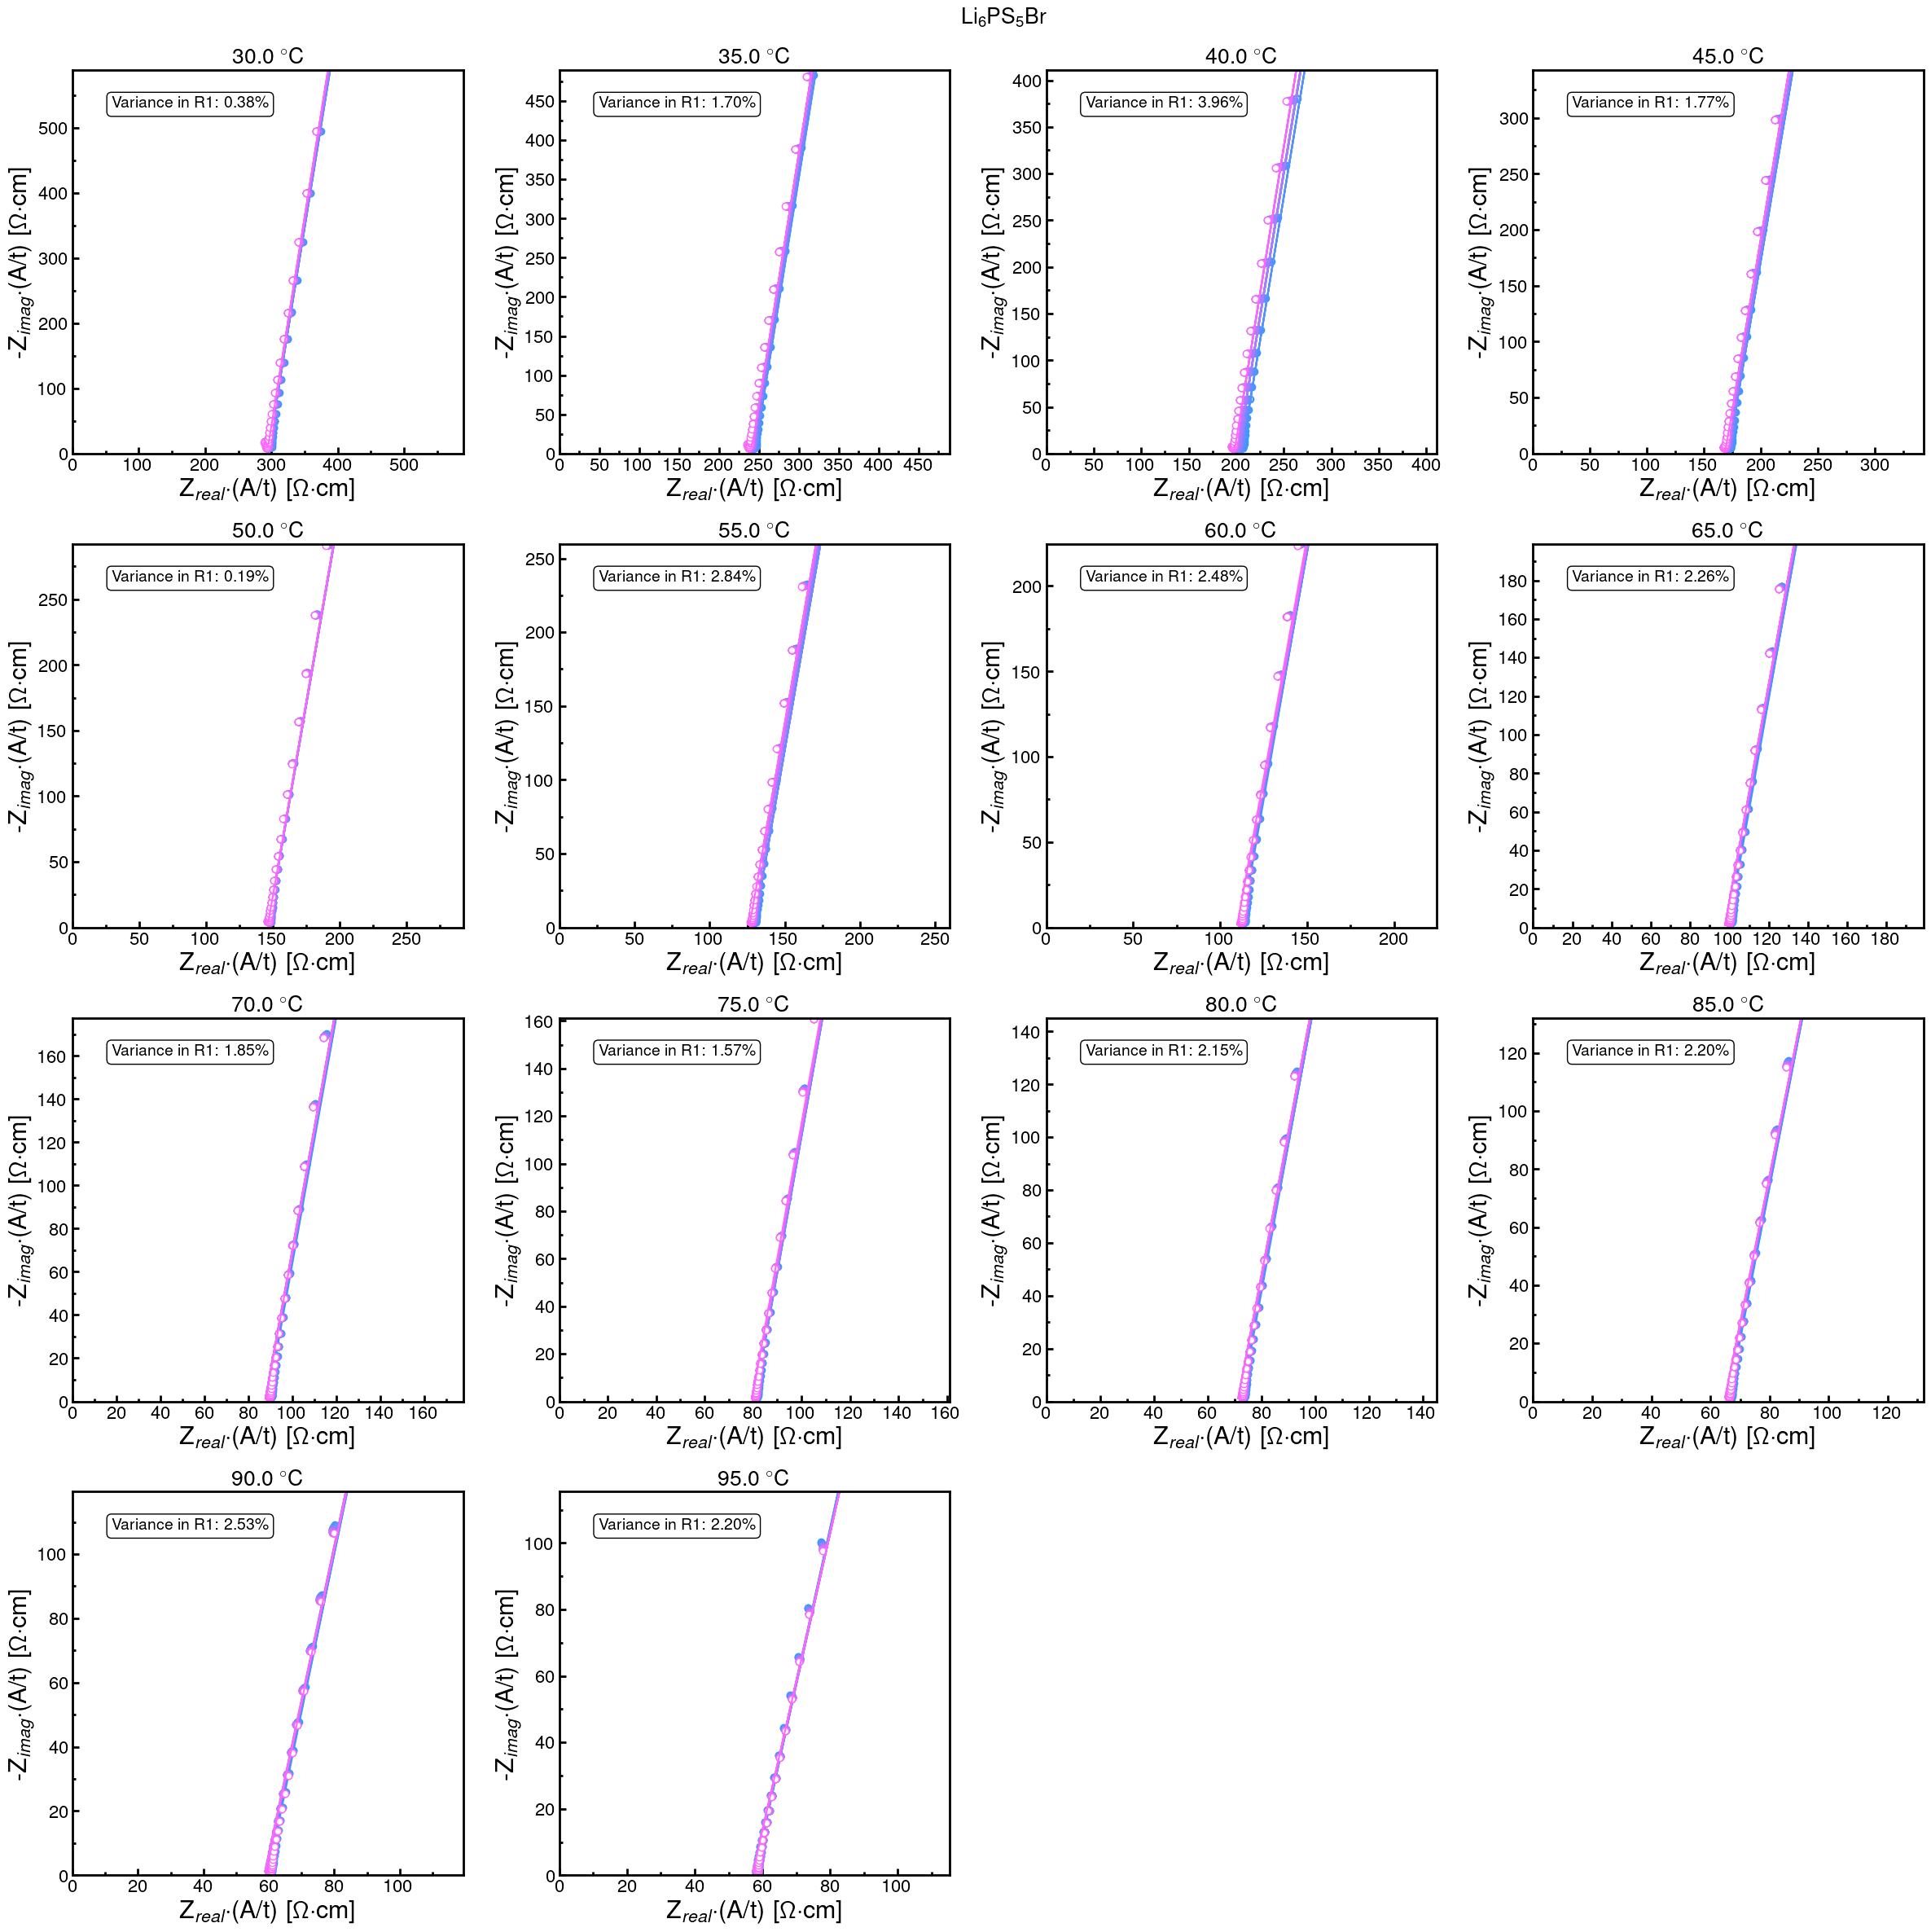

In [30]:
#generate dataframes that include raw data, fits, frequency, R1, and fs1 for neatly plotting the fits 
raw_nyquist=make_nyquist(experiments=all_experiments)

#This is Austin's advanced plotting functionality! Guaranteed* to make plots look reasonably nice if your fitting isn't absolute dogsh*t.
#*Guaranteed or your money back
#nyquist is the set of nyquist-style dataframes you want to plot
#plotall is a boolean that if true, will plot all of the temperatures in the nyquist dictionary
#selected_temperatures is which temperatures you want to plot. It is overridden if plotall=True
#normalize will normalize your data to area/thickness in centimeters
#start and end color are self explanatory
#limit_scalar sets the limit to a multiple of the fitted R1 value
#keep_last_n will only use the last # of replicates
#keep_first_n will only use the first # of replicates
#do not use both keep_last_n and keep_first_n
#exclude_keys allows you to specify a list of datasets that you do not want to plot, structured as exclude_keys=[(temp1,rep1),(temp2,rep2)]
#remove_outliers: whether to remove Modified Z-score outliers based on R1
#outlier_threshold: threshold for Modified Z-score to classify a point as an outlier, corresponds to median absolute deviations, 3.5=99.3% confidence
#returndatasets determines whether the code will return the nyquist datasets that were plotted. I recommend leaving this as True.

truncated_nyquist={}
truncated_nyquist=ausaplot_trunk(nyquist=raw_nyquist, plotall=True, selected_temperatures=[30], normalize=True,
             start_color="#3399ff", end_color="#ff66ff", limit_scalar=2,
             keep_last_n=None, keep_first_n=None, exclude_keys=[],
             remove_outliers=False, outlier_threshold=3.5,returndatasets=True)

#print(truncated_nyquist)

In [ ]:
#Decide here whether to use the truncated or non-truncated nyquist dataframes from above. 
#This function essentially serves to unify the variable names so that later processing runs well regardless
nyquist, R1_opt, Fs1_opt,experiments=to_truncate_or_not_to_truncate(raw_nyquist=raw_nyquist,truncated_nyquist=truncated_nyquist,all_experiments=all_experiments, use_truncated=True)


#Function takes R1, diameter, and height of pellet to get ionic conductivity, standard error in ionic conductivity (not confidence interval)
#confidence interval in the ionic conductivity, and, ionic conductivity at each replicate
ic, ic_err, ic_ci, sigma=calculate_IC_and_associated_error(R1_opt=R1_opt,diameter=diameter,height=height,print_values=True,alpha=0.05)

In [ ]:
#this function does the arrhenius fit!
arrh_r_sq, arrh_y_int, arrh_slope, E, CI_E, CI_int, CI_slope=arrhenius_fit_and_extract_Ea_and_confidence_interval(ic=ic,ic_err=ic_err,alpha=0.05,print_values=True)

#prefactor fun-- we are going to calculate the prefactor and confidence interval here!
prefactor, prefactor_error=calculate_prefactor_and_confidence_interval (arrh_y_int,CI_int,print_values=True)

#This function makes the arrhenius plot
T_K,T_K_inv,ln_sig_T,ln_sig_T_err=arrhenius_plot(ic=ic, error=ic_ci, y_int=arrh_y_int, slope=arrh_slope,r_squared=arrh_r_sq,E=E, CI_E=CI_E, prefactor=prefactor, prefactor_error=prefactor_error)

In [ ]:
#this cell defines the function for generating arrhenius dataframe for exporting data. modify as needed.
def generate_arrhenius_df(T_K,T_K_inv,ln_sig_T,ln_sig_T_err,m,b,E,CI_E,r_sq,ic,ic_ci,prefactor,prefactor_error,samplename=samplename,materialname=materialname,show_table=True):
    #Generate a pandas dataframe with all the relevant parameters from the arrhenius fit
    slope=[m.item()]*len(T_K)
    intercept=[b]*len(T_K)
    Ea=[E.item()]*len(T_K)
    CI_Ea=[CI_E]*len(T_K)
    samplenamez=[samplename]*len(T_K)
    materialnamez=[materialname]*len(T_K)
    r_sqs=[r_sq]*len(T_K)
    conductivityz=[ic[30]]*len(T_K)
    moez=[ic_ci[30]]*len(T_K)
    moez_prefactor=[prefactor_error]*len(T_K)
    meanz_prefactor=[prefactor]*len(T_K)
    
    arrhenius_export_df = pd.DataFrame({
        r'sample name':samplenamez,
        r'material name':materialnamez,
        r'Temperature (K)':T_K,
        r'1/$\textit{T}$ (K$^{-1}$)': T_K_inv,
        r'ln($\sigma\textit{T}$) (S$\cdot$cm$^{-1}\cdot$K)': ln_sig_T,
        r'y error in ln($\sigma$\textit{T}) (confidence interval)':ln_sig_T_err,
        r'Arrhenius Slope':slope,
        r'Arrhenius Y-intercept':intercept,
        r'Arrhenius r$^2$':r_sqs,
        r'E$_A$':Ea,
        r'E$_A$ confidence interval':CI_Ea,
        r'$\sigma_{30~^\circ C}$':conductivityz,
        r'$\sigma_{30~^\circ C}$ confidence interval':moez,
        r'$\sigma_0$':meanz_prefactor,
        r'$\sigma_0$ confidence interval':moez_prefactor
    })
    if show_table:
        display(arrhenius_export_df)

    return arrhenius_export_df

In [ ]:
arrhenius_export_df=generate_arrhenius_df(T_K=T_K,T_K_inv=T_K_inv,ln_sig_T=ln_sig_T,ln_sig_T_err=ln_sig_T_err,m=arrh_slope,b=arrh_y_int,E=E,CI_E=CI_E,r_sq=arrh_r_sq,ic=ic,ic_ci=ic_ci,prefactor=prefactor,prefactor_error=prefactor_error,samplename=samplename,materialname=materialname,show_table=False)

if ready2export:
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
    clean_matname_and_save (dataframe=arrhenius_export_df, save_folder=save_folder, savename="arrhenius_summary", save_sub_folder="Arrhenius summaries")

In [ ]:
#define function to generate latex formatted table of fitted parameters and reindex the experiments starting at 1
#reindexing is so that the table doesn't say something silly like replicate 2,5,9

def generate_fitted_param_table_and_reindex_experiments(experiments,show_table=True):
    #leading resistor
    R1={}
    #parallel Resistor
    R2={}
    #parallel constant phase element
    Q2={}
    n2={}
    #tailing constant phase element
    Q3={}
    n3={}
    
    capacitance={}
    char_freq={}
    
    for key, exp_instance in experiments.items():
        R1[key]=float(exp_instance.fit_Rs[0])
        R2[key]=float(exp_instance.fit_R1[0])
        n2[key]=float(exp_instance.fit_n1[0])
        Q2[key]=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0])
        capacitance[key]=(((Q2[key]*R2[key])**(1/n2[key]))/R2[key])
        char_freq[key]=float(exp_instance.fit_fs1[0])
        n3[key]=float(exp_instance.fit_n[0])
        Q3[key]=float(exp_instance.fit_Q[0])
        
        
    #print(R2)
    # Create a mapping from old keys to new keys
    
    new_keys_mapping = {}
    counters = {}
    
    for key in R2.keys():
        if key[0] not in counters:
            counters[key[0]] = 1
        new_keys_mapping[key] = (key[0], counters[key[0]])
        counters[key[0]] += 1
    
    # Function to reindex dictionaries based on new_keys_mapping
    def reindex_dict(original_dict):
        new_dict = {}
        for old_key, value in original_dict.items():
            new_key = new_keys_mapping[old_key]
            new_dict[new_key] = value
        return new_dict
    
    # Reindex all dictionaries
    R1_new = reindex_dict(R1)
    R2_new = reindex_dict(R2)
    n2_new = reindex_dict(n2)
    Q2_new = reindex_dict(Q2)
    n3_new = reindex_dict(n3)
    Q3_new = reindex_dict(Q3)
    sigma_new=reindex_dict(sigma)
    capacitance_new=reindex_dict(capacitance)
    char_freq_new=reindex_dict(char_freq)
    reindexed_experiments=reindex_dict(experiments)
    
    #print(reindexed_experiments)
    #print(R2_new)
    
    # Combine reindexed dictionaries into a single DataFrame
    refinedparams = {
        r'$T$ ($^\circ$C)': [key[0] for key in R1_new.keys()],
        'Replicate Scan': [key[1] for key in R1_new.keys()],
        r'R$_0$ ($\Omega$)': list(R1_new.values()),
        r'$R_1$ ($\Omega$)': list(R2_new.values()),
        r'$\sigma$ (S cm$^{-1}$)':list(sigma_new.values()),
        r'$n_1$': list(n2_new.values()),
        r'$Q_1$(S/s$^n$)': list(Q2_new.values()),
        r'$C_1$ (F)': list(capacitance_new.values()),
        r'$\tau_{1}$ (Hz)': list(char_freq_new.values()),
        r'$n_2$': list(n3_new.values()),
        r'$Q_2$(S/s$^n$)': list(Q3_new.values())
        
    }
    
    refinedparams = pd.DataFrame(refinedparams)
    
    
    
    
    #roundedrefinedparams=refinedparams.round(2)
    def scientific_notation(x):
        return f"{x:.2e}"
    
    
    columns_to_sci = [r'R$_0$ ($\Omega$)',r'$R_1$ ($\Omega$)',r'$Q_1$(S/s$^n$)',r'$C_1$ (F)',r'$Q_2$(S/s$^n$)',r'$\sigma$ (S cm$^{-1}$)',r'$\tau_{1}$ (Hz)']
    refinedparams[columns_to_sci] = refinedparams[columns_to_sci].map(scientific_notation)
    columns_to_round=[r'$n_1$',r'$n_2$']
    refinedparams[columns_to_round]=refinedparams[columns_to_round].round(2)
    #Add '&' columns and '\' at the end of each row
    for col in refinedparams.columns[:-1]:
        refinedparams.insert(refinedparams.columns.get_loc(col)+1, '&', '&',allow_duplicates=True)
    
    # Add the '\\' column at the end
    refinedparams['\\\\'] = '\\\\'
    if show_table:    
        display(refinedparams)

    return refinedparams,reindexed_experiments

In [ ]:
refined_params_table,reindexed_experiments=generate_fitted_param_table_and_reindex_experiments(experiments=experiments,show_table=False)

if ready2export:
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
    clean_matname_and_save (dataframe=refined_params_table, save_folder=save_folder, savename="fitted_echem_parameters", save_sub_folder="fitted echem parameters")

In [ ]:
#this cell defines the function for generating reindexed nyquist dataframes for exporting data. modify as needed.
def generate_export_nyquist_dataframes(experiments,start_frequency=2*10**6,stop_frequency=0.2,pts_decade=10,show_dataframes=True):
    f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
    
    #This chunk of code generates a simulated dataset using the parameters from the initial modelling above
    sim={}

    # Iterate through the outer dictionary (temperature-wise experiments)
    for key, exp_instance in experiments.items():
        sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
        sim[key]=sim_temp

    #here we make a bunch of dataframes with all of the info we need for nyquist plots
    export_nyquist_df={}
    # Iterate through the outer dictionary (temperature-wise experiments)
    for key, exp_instance in experiments.items():
        min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[key].real), len(sim[key].imag),len(exp_instance.df_raw.f))
        key_temp=[key]*min_length
        samplenamez=[samplename]*min_length
        materialnamez=[materialname]*min_length
        diameterz=[diameter]*min_length
        heightz=[height]*min_length
        # Truncate arrays to the minimum length
        truncated_re = exp_instance.df_raw.re[:min_length]
        truncated_im = exp_instance.df_raw.im[:min_length]
        truncated_f= exp_instance.df_raw.f[:min_length]
        truncated_fit_real = sim[key].real[:min_length]
        truncated_fit_imag = -sim[key].imag[:min_length]
        
        # Create DataFrame with truncated arrays
        export_nyquist_df[key] = pd.DataFrame({
            'Frequency':truncated_f,
            'Z real': truncated_re,
            'Z imag': truncated_im,
            'Fit real': truncated_fit_real,
            'Fit imag': truncated_fit_imag,
            'Dataset':key_temp,
            'sample_name':samplenamez,
            'material_name':materialnamez,
            'height':heightz,
            'diameter':diameterz
        })
    if show_dataframes:
        display(export_nyquist_df)
    return export_nyquist_df

In [ ]:
export_nyquist_df=generate_export_nyquist_dataframes(experiments=reindexed_experiments,start_frequency=2*10**6,stop_frequency=0.2,pts_decade=10,show_dataframes=False)

if ready2export:
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
    for key,df in export_nyquist_df.items():
        clean_matname_and_save (dataframe=df, save_folder=save_folder, savename="nyquist", save_sub_folder="T_dep_nyquist", samplename=f"temp_{key[0]}_replicate_{key[1]}_{samplename}", materialname=materialname)